In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from resnet_model import new_ResNet18,old_ResNet18
import time
import pickle
import os
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
EPOCH = 20   #遍历数据集次数
BATCH_SIZE = 128      #批处理尺寸(batch_size)
LR = 0.001        #学习率 
Milestones=[135,185]
Debug=False

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='/root/GanLuo/PullSum_MNIST/code/神经网络实验/CIFAR10最终实验/cifar-10-python/cifar-10-batches-py', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/root/GanLuo/PullSum_MNIST/code/神经网络实验/CIFAR10最终实验/cifar-10-python/cifar-10-batches-py', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = new_ResNet18().to(device)
# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=Milestones,gamma = 0.1)

In [7]:
# 模型定义-ResNet
net = new_ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=2e-3)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=30

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)


Start Training, Resnet-18!


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch:1/30] Train Loss: 1.907 | Train Acc: 29.946% Test Loss: 2.122 | Test Acc: 38.240% Cost time: 0.12 min
[Epoch:2/30] Train Loss: 1.588 | Train Acc: 40.978% Test Loss: 1.912 | Test Acc: 44.680% Cost time: 0.11 min
[Epoch:3/30] Train Loss: 1.444 | Train Acc: 47.068% Test Loss: 1.716 | Test Acc: 51.070% Cost time: 0.12 min
[Epoch:4/30] Train Loss: 1.323 | Train Acc: 52.022% Test Loss: 1.693 | Test Acc: 52.560% Cost time: 0.11 min
[Epoch:5/30] Train Loss: 1.225 | Train Acc: 55.710% Test Loss: 1.512 | Test Acc: 57.780% Cost time: 0.11 min
[Epoch:6/30] Train Loss: 1.144 | Train Acc: 58.924% Test Loss: 1.483 | Test Acc: 58.830% Cost time: 0.11 min
[Epoch:7/30] Train Loss: 1.074 | Train Acc: 61.892% Test Loss: 1.358 | Test Acc: 62.470% Cost time: 0.11 min
[Epoch:8/30] Train Loss: 1.020 | Train Acc: 63.706% Test Loss: 1.336 | Test Acc: 62.900% Cost time: 0.11 min
[Epoch:9/30] Train Loss: 0.963 | Train Acc: 65.758% Test Loss: 1.223 | Test Acc: 66.200% Cost time: 0.11 min
[Epoch:10/30] Train

In [15]:
import pandas as pd
train_values = [t.item() for t in Train_Accuracy]  # 提取 Train_Accuracy 中的数值
test_values = [t.item() for t in Test_Accuracy]    # 提取 Test_Accuracy 中的数值

# 创建一个 DataFrame
df = pd.DataFrame({
    'Train_Accuracy': train_values,
    'Test_Accuracy': test_values
})

# 保存为 CSV 文件
df.to_csv('/root/GanLuo/PullSum_MNIST/code/神经网络实验/CIFAR10最终实验/数据保存/单机实验/纯SGD, lr=1e-3, 200步.csv', index=False)

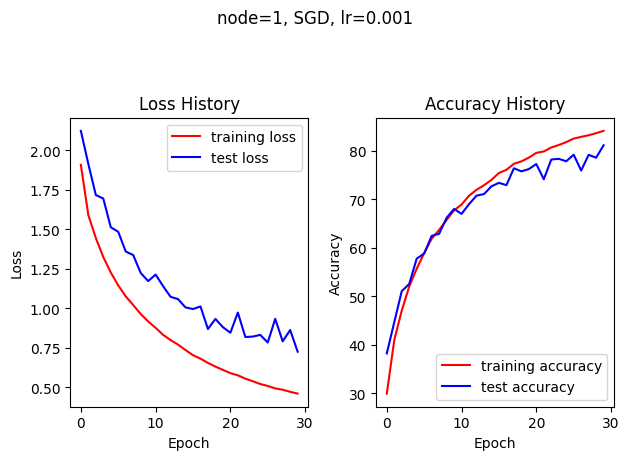

In [9]:
import matplotlib.pyplot as plt
from statistics import mean

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD, lr={LR}')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

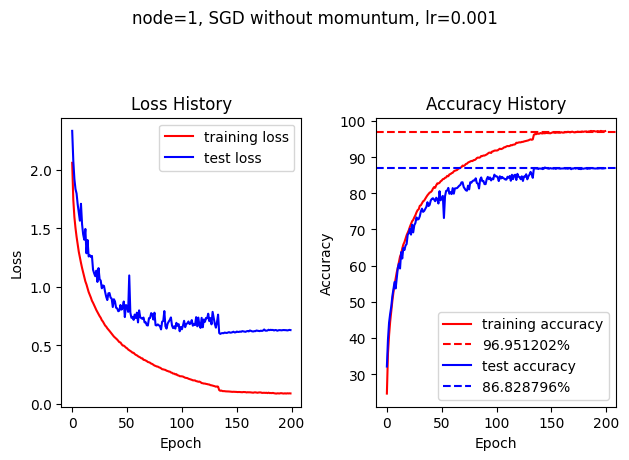

In [14]:
import matplotlib.pyplot as plt
from statistics import mean

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
number=torch.mean(torch.stack(Train_Accuracy[150:])).item()
plt.axhline(y=number, color='r', linestyle='--', label=f'{number:4f}%')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
number=torch.mean(torch.stack(Test_Accuracy[150:])).item()
plt.axhline(y=number, color='b', linestyle='--', label=f'{number:4f}%')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD without momuntum, lr={LR}')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

In [6]:
# 模型定义-ResNet
from torchvision.models import resnet18
model_class = lambda: resnet18(num_classes=10)
net = resnet18(num_classes=10).to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=50

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)


[Epoch:1/50] Train Loss: 2.155 | Train Acc: 21.296% Test Loss: 2.507 | Test Acc: 28.730% Cost time: 0.11 min
[Epoch:2/50] Train Loss: 1.903 | Train Acc: 30.350% Test Loss: 2.282 | Test Acc: 34.740% Cost time: 0.10 min
[Epoch:3/50] Train Loss: 1.784 | Train Acc: 34.356% Test Loss: 2.156 | Test Acc: 37.570% Cost time: 0.10 min
[Epoch:4/50] Train Loss: 1.704 | Train Acc: 36.920% Test Loss: 2.065 | Test Acc: 40.130% Cost time: 0.10 min
[Epoch:5/50] Train Loss: 1.647 | Train Acc: 39.414% Test Loss: 1.998 | Test Acc: 42.390% Cost time: 0.10 min
[Epoch:6/50] Train Loss: 1.606 | Train Acc: 40.776% Test Loss: 1.953 | Test Acc: 43.930% Cost time: 0.10 min
[Epoch:7/50] Train Loss: 1.570 | Train Acc: 42.196% Test Loss: 1.909 | Test Acc: 44.840% Cost time: 0.10 min
[Epoch:8/50] Train Loss: 1.542 | Train Acc: 43.548% Test Loss: 1.862 | Test Acc: 46.090% Cost time: 0.10 min
[Epoch:9/50] Train Loss: 1.512 | Train Acc: 44.682% Test Loss: 1.834 | Test Acc: 47.500% Cost time: 0.10 min
[Epoch:10/50] Train

In [ ]:
# 模型定义-ResNet
net = ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=100

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)


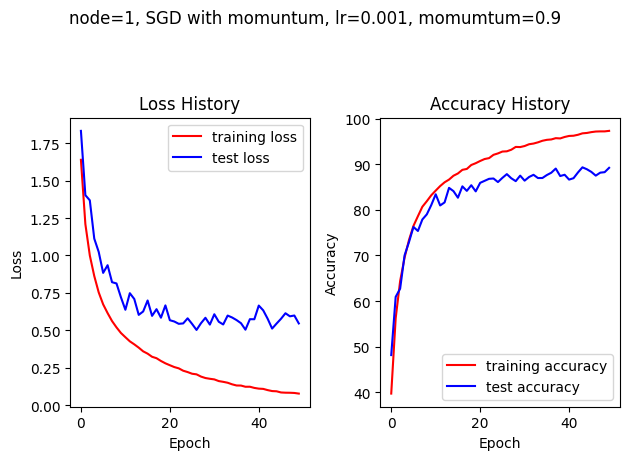

In [18]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD with momuntum, lr={LR}, momumtum=0.9')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

In [10]:
# 模型定义-ResNet
net = ResNet18Improved().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9,weight_decay=5e-4)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=60

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)

Start Training, Resnet-18!


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[Epoch:1/60] Train Loss: 1.753 | Train Acc: 34.034% Test Loss: 2.120 | Test Acc: 41.360% Cost time: 0.13 min
[Epoch:2/60] Train Loss: 1.384 | Train Acc: 49.206% Test Loss: 1.705 | Test Acc: 53.660% Cost time: 0.13 min
[Epoch:3/60] Train Loss: 1.187 | Train Acc: 57.132% Test Loss: 1.535 | Test Acc: 60.440% Cost time: 0.12 min
[Epoch:4/60] Train Loss: 1.059 | Train Acc: 61.792% Test Loss: 1.520 | Test Acc: 60.600% Cost time: 0.12 min
[Epoch:5/60] Train Loss: 0.972 | Train Acc: 65.346% Test Loss: 1.482 | Test Acc: 63.000% Cost time: 0.12 min
[Epoch:6/60] Train Loss: 0.903 | Train Acc: 68.050% Test Loss: 1.339 | Test Acc: 65.970% Cost time: 0.13 min
[Epoch:7/60] Train Loss: 0.841 | Train Acc: 70.224% Test Loss: 1.028 | Test Acc: 72.700% Cost time: 0.13 min
[Epoch:8/60] Train Loss: 0.785 | Train Acc: 72.498% Test Loss: 1.043 | Test Acc: 73.350% Cost time: 0.13 min
[Epoch:9/60] Train Loss: 0.740 | Train Acc: 74.028% Test Loss: 1.080 | Test Acc: 73.130% Cost time: 0.12 min
[Epoch:10/60] Train

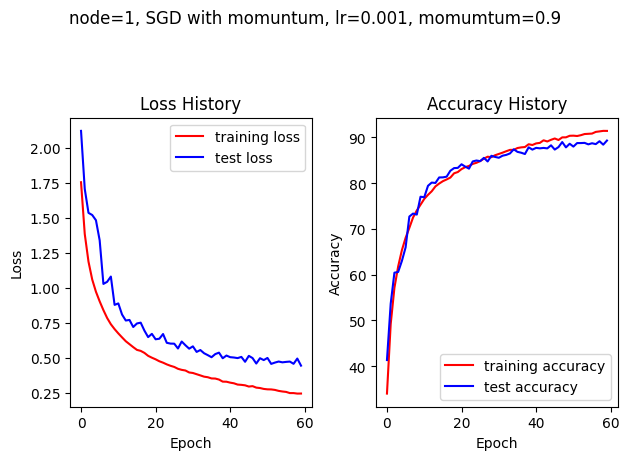

In [11]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD with momuntum, lr={LR}, momumtum=0.9')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()